In [1]:
import pandas as pd

# Load the uploaded dataset
file_path = '/content/Merged data.csv'
data = pd.read_csv(file_path)



In [2]:
data

,rounded_time,sentiment_score_textblob,sentiment_score_vader,Adj Close,Close,High,Low,Open,Volume
0,2023-01-31 00:00:00,0.142336,0.165558,22857.76563,22857.76563,22864.25195,22765.56836,22840.79688,0
1,2023-01-31 01:00:00,0.129171,0.178608,22858.32813,22858.32813,22870.33789,22797.08398,22855.97852,0
2,2023-01-31 02:00:00,0.164494,0.186917,22893.31836,22893.31836,22909.50195,22847.17969,22855.14844,0
3,2023-01-31 03:00:00,0.094387,0.158187,22861.80469,22861.80469,22890.26367,22858.86914,22890.26367,0
4,2023-01-31 04:00:00,0.106855,0.235430,22862.11719,22862.11719,22874.23047,22831.37891,22859.74414,0
...,...,...,...,...,...,...,...,...,...
2361,2023-06-05 22:00:00,0.220921,0.363787,25721.55273,25721.55273,25774.33398,25664.17188,25670.87500,0
2362,2023-06-05 23:00:00,0.170872,0.317972,25762.17969,25762.17969,25854.01172,25713.65234,25719.61328,0
2363,2023-06-06 00:00:00,0.130853,0.228462,25695.44336,25695.44336,25761.75977,25686.81445,25732.10938,0
2364,2023-06-06 01:00:00,0.213958,0.296732,25648.05469,25648.05469,25704.13672,25636.39453,25697.46289,0


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prepare the features and target
features = data[['sentiment_score_textblob', 'sentiment_score_vader', 'Close', 'High', 'Low', 'Open', 'Volume']]
target = data['Adj Close']

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Create sequences for LSTM
sequence_length = 10
X_lstm = []
y_lstm = []

for i in range(sequence_length, len(target_scaled)):
    X_lstm.append(features_scaled[i-sequence_length:i])  # 10 timesteps of features
    y_lstm.append(target_scaled[i])  # Target for the next step

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split data into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, random_state=42, shuffle=False
)

# Build LSTM model
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = lstm_model.fit(
    X_train_lstm, y_train_lstm, epochs=20, batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm), verbose=0
)

# Predict using the LSTM model
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm)  # Rescale predictions
y_test_lstm_rescaled = target_scaler.inverse_transform(y_test_lstm)  # Rescale actual values

# Evaluate the LSTM model
mae_lstm = mean_absolute_error(y_test_lstm_rescaled, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_rescaled, y_pred_lstm))

# Create a comparison results DataFrame
results = pd.DataFrame({
    'Model': ['LSTM'],
    'MAE': [mae_lstm],
    'RMSE': [rmse_lstm]
})

results

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


,Model,MAE,RMSE
0,LSTM,390.327579,475.803529


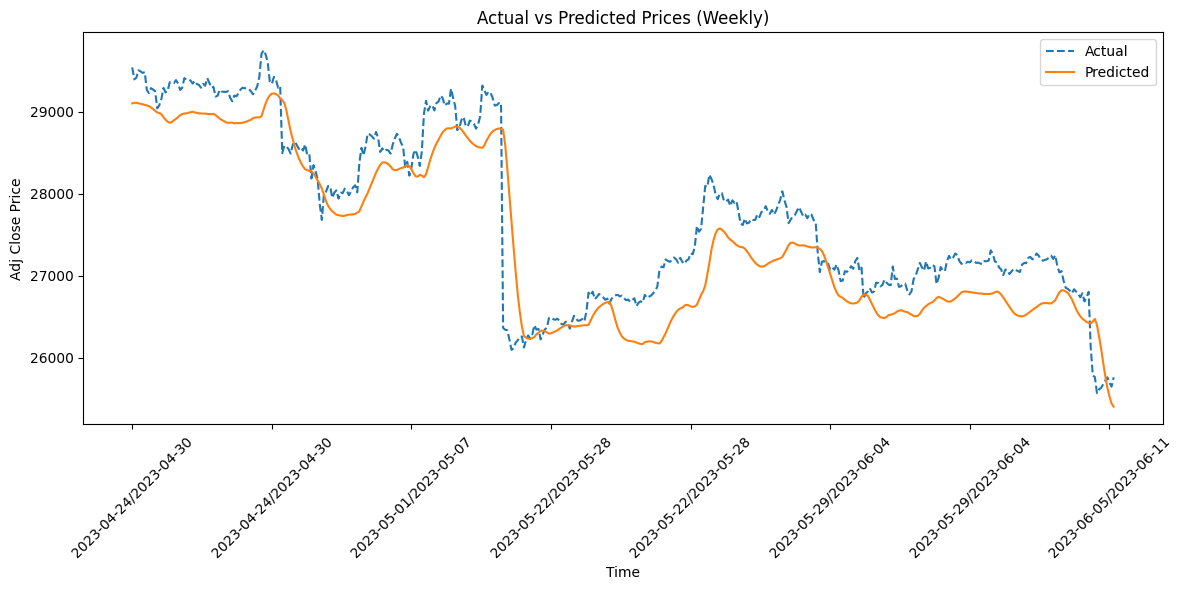

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'rounded_time' to datetime format
data['rounded_time'] = pd.to_datetime(data['rounded_time'])

# Extract the timestamps for the test set
timestamps = data['rounded_time'].iloc[-len(y_test_lstm_rescaled):]

# Resample to weekly intervals for x-axis
weekly_timestamps = timestamps.dt.to_period('W').astype(str)  # Convert to weekly periods
weekly_indices = [i for i in range(len(timestamps)) if i % (len(timestamps) // 7) == 0]  # Select approximately weekly indices
weekly_labels = [weekly_timestamps.iloc[i] for i in weekly_indices]

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm_rescaled, label='Actual', linestyle='--')
plt.plot(y_pred_lstm, label='Predicted')
plt.title('Actual vs Predicted Prices (Weekly)')
plt.xlabel('Time')
plt.ylabel('Adj Close Price')
plt.xticks(weekly_indices, weekly_labels, rotation=45)  # Set weekly labels and rotate
plt.legend()
plt.tight_layout()
plt.show()
